# Inversion of random total-magnetization directions

This notebook

In [1]:
import numpy as np
import mplstereonet as msn
import matplotlib.pyplot as plt
import cPickle as pickle
import os

from fatiando.utils import ang2vec

In [2]:
from datetime import date
today = date.today()
# dd/mm/YY
d4 = today.strftime("%b-%d-%Y")

In [3]:
import sys
sys.path.insert(0, '../../code')

import mag_polyprism_functions as mfun

/home/leonardo/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


# Input

### Importing model parameters

In [4]:
model_dir = 'data/model.pickle'
data_dir = 'data/flightlines_grid_2100pts_100k/data.pickle'
grid_dir = '../grids/flightlines_grid_2100pts_100km2_-150m.pickle'
directions_dir = 'data/flightlines_grid_2100pts_100k/both_inversion/num15_d30/directions.pickle'

In [5]:
with open(model_dir) as w:
        model = pickle.load(w)

In [6]:
with open(grid_dir) as w:
        grid = pickle.load(w)

In [7]:
with open(data_dir) as w:
        data = pickle.load(w)

In [8]:
with open(directions_dir) as w:
        rd = pickle.load(w)

In [9]:
xp = grid['x']
yp = grid['y']
zp = grid['z']
tfa = data['tfa_obs']
amf = data['amf_obs']
incs = rd['directions'][0]
decs = rd['directions'][1]

In [10]:
M = 20 # number of vertices per prism
L = 5 # number of prisms
P = L*(M+2) + 1 # number of parameters

# magnetization intensity
intensity = model['intensity']

# depth to the top, thickness and radius
z0 = model['z0']
dz = 350.
r = 2000.

x0 = 0.
y0 = 0.

# main field
inc, dec = data['main_field']

### Directions

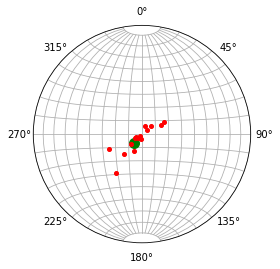

In [11]:
fig, ax = msn.subplots()

ax.pole(model['inc'], model['dec'], markersize=10, color='g')
ax.pole(incs, decs, markersize=4, color='red')
ax.grid(True)

plt.show()

### Limits

In [12]:
# limits for parameters in meters
rmin = 10.
rmax = 3000.
x0min = -1000.
x0max = 1000.
y0min = -1000.
y0max = 1000.
dzmin = 10.
dzmax = 1000.

mmin, mmax = mfun.build_range_param(M, L, rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax)

### Variation

In [13]:
# variation for derivatives
deltax = 0.01*np.max(1000.)
deltay = 0.01*np.max(1000.)
deltar = 0.01*np.max(rmax)
deltaz = 0.01*np.max(dzmax)

### Outcropping parameters

In [14]:
# outcropping body parameters
m_out = np.zeros(M + 2)
#m_out = model['param_vec'][:M+2]

In [15]:
# output of inversion
inversion = dict()

### Regularization parameters

In [16]:
#lamb = th*0.01 # Marquadt's parameter
lamb = 10.0
dlamb = 10.      # step for Marquadt's parameter

a1 = 1.0e-3  # adjacent radial distances within each prism
a2 = 1.0e-4   # vertically adjacent radial distances
a3 = 0.     # outcropping cross-section
a4 = 0.     # outcropping origin
a5 = 1.0e-4     # vertically adjacent origins
a6 = 1.0e-6   # zero order Tikhonov on adjacent radial distances
a7 = 1.0e-5     # zero order Tikhonov on thickness of each prism

In [17]:
delta = np.array([deltax, deltay, deltar, deltaz])
alpha = np.array([a1, a2, a3, a4, a5, a6, a7])

In [18]:
itmax = 30
itmax_marq = 10
tol = 1.0e-4     # stop criterion

In [19]:
inversion['x'] = xp
inversion['y'] = yp
inversion['z'] = zp

In [20]:
inversion['z0'] = z0
inversion['initial_dz'] = dz
inversion['intial_r'] = r
inversion['limits'] = [rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax]
inversion['regularization'] = alpha
inversion['tol'] = tol

# Inversion

### AMF inversion

In [21]:
amf_results = []
k=1
for i, d in zip(incs,decs):
    alpha = np.array([a1, a2, a3, a4, a5, a6, a7])
    print 'inversion: %d  inclination: %d  declination: %d' % (k, i, d)
    model0, m0 = mfun.initial_cylinder(M, L, x0, y0, z0, dz, r, inc, dec, i, d, intensity)
    d_fit, m_est, model_est, phi_list, model_list, res_list = mfun.levmarq_amf(
        xp, yp, zp, m0, M, L, delta,
        itmax, itmax_marq, lamb,
        dlamb, tol, mmin, mmax,
        m_out, amf,
        model0[0].props, alpha, z0, dz
    )
    amf_results.append([m_est, phi_list, model_list, amf - d_fit])
    k+=1

inversion: 1  inclination: -44  declination: 4
it:  0   it_marq:  0   lambda: 1e+01   init obj.: 2.00620e+05  fin obj.: 1.05926e+05
it:  1   it_marq:  0   lambda: 1e+00   init obj.: 1.05926e+05  fin obj.: 3.55486e+04
it:  2   it_marq:  0   lambda: 1e-01   init obj.: 3.55486e+04  fin obj.: 1.36589e+04
it:  3   it_marq:  0   lambda: 1e-02   init obj.: 1.36589e+04  fin obj.: 1.83676e+04
it:  3   it_marq:  1   lambda: 1e-01   init obj.: 1.36589e+04  fin obj.: 4.84952e+03
it:  4   it_marq:  0   lambda: 1e-02   init obj.: 4.84952e+03  fin obj.: 1.13442e+05
it:  4   it_marq:  1   lambda: 1e-01   init obj.: 4.84952e+03  fin obj.: 1.00839e+04
it:  4   it_marq:  2   lambda: 1e+00   init obj.: 4.84952e+03  fin obj.: 3.23008e+03
it:  5   it_marq:  0   lambda: 1e-01   init obj.: 3.23008e+03  fin obj.: 1.23073e+04
it:  5   it_marq:  1   lambda: 1e+00   init obj.: 3.23008e+03  fin obj.: 3.68012e+03
it:  5   it_marq:  2   lambda: 1e+01   init obj.: 3.23008e+03  fin obj.: 3.31614e+03
it:  5   it_marq: 

### TFA inversion

In [22]:
tfa_results = []
k=1
for i, d in zip(incs,decs):
    alpha = np.array([a1, a2, a3, a4, a5, a6, a7])
    print 'inversion: %d  inclination: %d  declination: %d' % (k, i, d)
    model0, m0 = mfun.initial_cylinder(M, L, x0, y0, z0, dz, r, inc, dec, i, d, intensity)
    d_fit, m_est, model_est, phi_list, model_list, res_list = mfun.levmarq_tf(
        xp, yp, zp, m0, M, L, delta,
        itmax, itmax_marq, lamb,
        dlamb, tol, mmin, mmax,
        m_out, tfa, inc, dec,
        model0[0].props, alpha, z0, dz
    )
    tfa_results.append([m_est, phi_list, model_list, tfa - d_fit])
    k+=1

inversion: 1  inclination: -44  declination: 4
it:  0   it_marq:  0   lambda: 1e+01   init obj.: 1.08151e+05  fin obj.: 4.77052e+04
it:  1   it_marq:  0   lambda: 1e+00   init obj.: 4.77052e+04  fin obj.: 8.73630e+03
it:  2   it_marq:  0   lambda: 1e-01   init obj.: 8.73630e+03  fin obj.: 4.87692e+03
it:  3   it_marq:  0   lambda: 1e-02   init obj.: 4.87692e+03  fin obj.: 8.63036e+03
it:  3   it_marq:  1   lambda: 1e-01   init obj.: 4.87692e+03  fin obj.: 4.29345e+03
it:  4   it_marq:  0   lambda: 1e-02   init obj.: 4.29345e+03  fin obj.: 2.45688e+04
it:  4   it_marq:  1   lambda: 1e-01   init obj.: 4.29345e+03  fin obj.: 6.78196e+03
it:  4   it_marq:  2   lambda: 1e+00   init obj.: 4.29345e+03  fin obj.: 1.24184e+03
it:  5   it_marq:  0   lambda: 1e-01   init obj.: 1.24184e+03  fin obj.: 6.54154e+03
it:  5   it_marq:  1   lambda: 1e+00   init obj.: 1.24184e+03  fin obj.: 1.00392e+03
it:  6   it_marq:  0   lambda: 1e-01   init obj.: 1.00392e+03  fin obj.: 6.49331e+03
it:  6   it_marq: 

In [23]:
inversion['amf_results'] = amf_results
inversion['tfa_results'] = tfa_results

### Folder to save the results

In [24]:
filename = directions_dir[:-17]+'inversion_'
filename += d4+'.pickle'
with open(filename, 'w') as f:
    pickle.dump(inversion, f)